In [1]:
import tensorflow as tf
import os
from glob import glob

import cv2
import numpy as np
from tqdm import tqdm
import numpy as np

import cProfile
tf.enable_eager_execution()

BUFFER_SIZE = 400

Download data

In [2]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz

--2019-12-21 06:59:27--  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243346528 (232M) [application/x-gzip]
Saving to: ‘lfw-funneled.tgz’

lfw-funneled.tgz    100%[===================>] 232.07M  73.2MB/s    in 3.3s    

2019-12-21 06:59:31 (69.8 MB/s) - ‘lfw-funneled.tgz’ saved [243346528/243346528]



In [0]:
!mv lfw-funneled.tgz lfwfunneled.tgz

In [0]:
!mkdir lfwfunneled

In [0]:
!tar -C ./lfwfunneled -xvf lfwfunneled.tgz 

In [0]:
im_names = glob("lfwfunneled/lfw_funneled/*/*.jpg")

In [3]:
im_names[1]

'lfwfunneled/lfw_funneled/Kathleen_Kennedy_Townsend/Kathleen_Kennedy_Townsend_0001.jpg'

In [0]:
import random
ten_images = random.sample(im_names, 10)

In [0]:
ten_images = random.sample(im_names, 10)

Plot some images

In [0]:
%matplotlib inline

import os
import random
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np

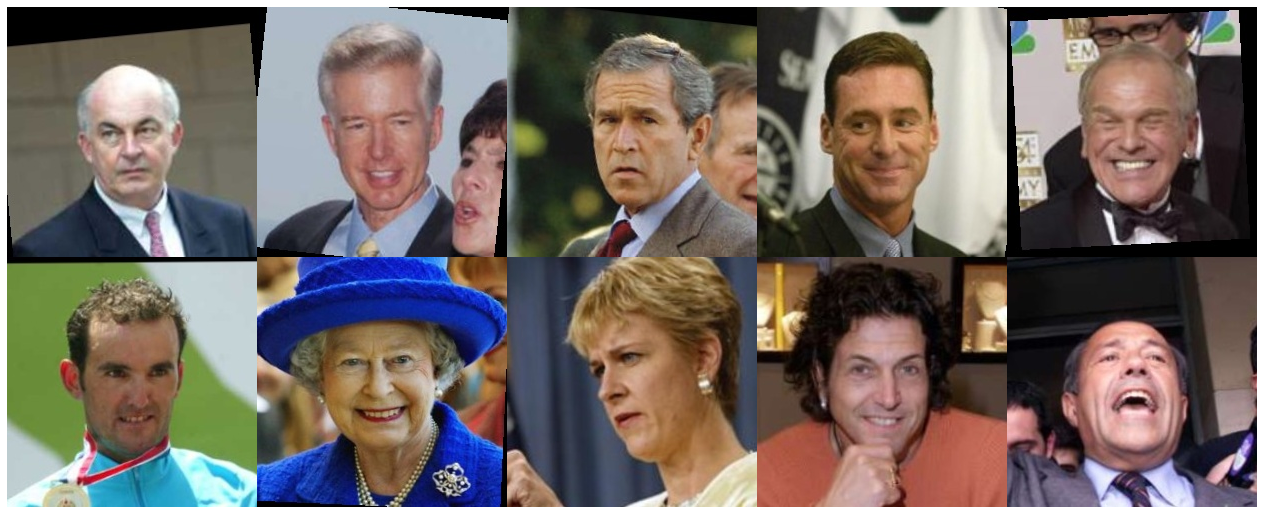

In [0]:
grid=[]
for i in range(2):
  col_im = []
  for j in range(5):
    if i==0:
      col_im.append(cv2.imread(ten_images[j]))
    else:
      col_im.append(cv2.imread(ten_images[j+5]))
  grid.append(np.column_stack(col_im))
image = np.row_stack(grid)
dpi = float(plt.rcParams['figure.dpi'])
figsize = image.shape[1] / dpi, image.shape[0] / dpi
ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(image[..., ::-1])
plt.show()

In [0]:
im = cv2.imread(im_names[0], cv2.IMREAD_GRAYSCALE)

In [0]:
avg_image = np.zeros_like(im, dtype=np.float32)

Calculate the average image

In [0]:
for i in im_names:
  im = cv2.imread(i, cv2.IMREAD_GRAYSCALE).astype('float32')
  avg_image += im/13233

In [0]:
avg_image.shape

(250, 250)

Plot average image

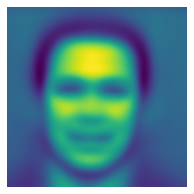

In [0]:
grid = []
grid.append(np.column_stack([avg_image[30:210,30:210]]))
image = np.row_stack(grid)
dpi = float(plt.rcParams['figure.dpi'])
figsize = image.shape[1] / dpi, image.shape[0] / dpi
ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(image[..., ::-1])
plt.show()

Most faces fall in a 180 by 180 square

In [0]:
avg_image[30:210,30:210].shape

(180, 180)

## Create dataset

Collect positive and negative pairs

In [0]:
only_one=[]
for i in os.walk("/content/lfwfunneled/lfw_funneled"):
  if len(os.listdir(i[0]))<2:
    only_one.append(i[0])

In [0]:
more_than_one = []
for i in os.walk("/content/lfwfunneled/lfw_funneled"):
  if len(os.listdir(i[0]))>=2:
    more_than_one.append(i[0])
#more_than_one = [i for i in more_than_one if i.endswith('.jpg')]

In [0]:
only_one = list(filter(lambda x: len(x.split('/'))>4, only_one))

In [0]:
more_than_one = list(filter(lambda x: len(x.split('/'))>4, more_than_one))

In [0]:
from random import sample
from random import random
from random import shuffle

Train-test-val split

In [0]:
shuffle(more_than_one)

In [0]:
val_test_pos = more_than_one[1500:]
val_test_neg = only_one[3000:]

In [0]:
train_pos = more_than_one[:1500]*2
shuffle(train_pos)
train_neg = only_one[:3000]

In [0]:
val_pos = val_test_pos[:90]
test_pos = val_test_pos[90:]

In [0]:
val_neg = val_test_neg[:530]
test_neg = val_test_neg[530:]

Create dataset generator

In [0]:
class myDataset():
  def __init__(self, positive_names, negative_names):
    self.positives = positive_names
    self.negative = negative_names
    self.base_path = ""
    #could merge and create a larger dataset for negatives
  def __iter__(self):
    while True:
      yield self.get_pair()
  def get_positive_name(self):
    return sample(self.positives, 1)
  
  def get_negative_names(self):
    return sample(self.negative, 2)
  
  def get_pair(self):
    if random()>0.5:
      label = np.float32(1.0)
      name = self.get_positive_name()
      file_names = sample(os.listdir(os.path.join(self.base_path, name[0])), 2)
      file_names = label,os.path.join(*[self.base_path, name[0], file_names[0]]).encode('utf-8'), os.path.join(*[self.base_path, name[0], file_names[1]]).encode('utf-8')
    else:
      label = np.float32(0.0)
      name = self.get_negative_names()
      file_name1 = sample(os.listdir(os.path.join(self.base_path, name[0])), 1)[0]
      file_name2 = sample(os.listdir(os.path.join(self.base_path, name[1])), 1)[0]
      file_names = label,os.path.join(*[self.base_path, name[0], file_name1]).encode('utf-8'), os.path.join(*[self.base_path, name[1], file_name2]).encode('utf-8')
    return file_names

In [0]:
train_ = myDataset(train_pos,train_neg)
val_ = myDataset(val_pos,val_neg)
test_ = myDataset(test_pos, test_neg)

Create TF dataset

In [0]:
def parse_fn(l,x,y):
  x = tf.io.read_file(x)
  x = tf.image.decode_jpeg(x, channels=3)
  x = tf.image.random_brightness(x, 10)    # aument images with random brightness
  x = tf.image.crop_to_bounding_box(x, 30, 30, 180, 180)
  
  x = tf.cast(x, tf.float32) / 255.0
  x = tf.clip_by_value(x, 0.0, 1.0)

  y = tf.io.read_file(y)
  y = tf.image.decode_jpeg(y, channels=3)
  y = tf.image.random_brightness(y, 10)    # aument images with random brightness
  y = tf.image.crop_to_bounding_box(y, 30, 30, 180, 180)
  #
  y = tf.cast(y, tf.float32) / 255.0
  y = tf.clip_by_value(y, 0.0, 1.0)   #clip values between 0 and 1
  return l,x,y
  
ds = tf.data.Dataset.from_generator(lambda :train_, output_types=(tf.float32,tf.string, tf.string))
ds = ds.map(lambda l,x,y: parse_fn(l,x,y))
ds = ds.shuffle(BUFFER_SIZE)
ds = ds.batch(32, drop_remainder=True)
ds = ds.repeat(None)

# Approach
The two images will be processed by a network to create embeddings of the images. The weights will be shared by the networks that process the two images.
The absolute difference between the two embeddings are calculated and this is passed through a dense network to score similarity

The embedding network will consist of residual blocks which are defined below

Residual block

Embedding model that converts image to its embedding

In [0]:
class Image2Vec(tf.keras.Model):
  def __init__(self):
    super(Image2Vec, self).__init__(name='')

    self.conv1 = tf.keras.layers.Conv2D(64, (7, 7), strides=(2,2), padding='same')
    self.relu1 = tf.keras.layers.ReLU()
    self.bn1 = tf.keras.layers.BatchNormalization()

    self.conv2 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2,2), padding='same')
    self.relu2 = tf.keras.layers.ReLU()
    self.bn2 = tf.keras.layers.BatchNormalization()

    self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), strides=(2,2), padding='same')
    self.relu3 = tf.keras.layers.ReLU()
    self.bn3 = tf.keras.layers.BatchNormalization()

    self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), strides=(2,2), padding='same')
    self.relu4 = tf.keras.layers.ReLU()
    self.bn4 = tf.keras.layers.BatchNormalization()

    self.conv5 = tf.keras.layers.Conv2D(512, (3, 3), strides=(2,2), padding='same')
    self.relu5 = tf.keras.layers.ReLU()
    self.bn5 = tf.keras.layers.BatchNormalization()

    self.conv6 = tf.keras.layers.Conv2D(512, (3, 3), strides=(2,2), padding='same')
    self.relu6 = tf.keras.layers.ReLU()
    self.bn6 = tf.keras.layers.BatchNormalization()

    #self.avgpool = tf.keras.layers.AveragePooling2D(pool_size=(6,6))
    self.flatten = tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(1024)

  def call(self, input_tensor, training=False):
    x = self.bn1(self.relu1(self.conv1(input_tensor)))
    x = self.bn2(self.relu2(self.conv2(x)))
    x = self.bn3(self.relu3(self.conv3(x)))
    x = self.bn4(self.relu4(self.conv4(x)))
    x = self.bn5(self.relu5(self.conv5(x)))
    x = self.bn6(self.relu6(self.conv6(x)))
    # x = self.avgpool(x)
    x = self.flatten(x)
    x = self.dense(x)
    return x

In [0]:
im2vec = Image2Vec()

Bring everything together

Create optimizer

In [0]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-4)
margin = 1.0

Define training step, contrastive loss is used to train the model

In [0]:
@tf.function
def train_step(label,x, y):
  with tf.GradientTape() as grad_tape:
    x = im2vec(x)
    y = im2vec(y)
    d = tf.reduce_sum(tf.square(x - y), 1)
    d_sqrt = tf.sqrt(d)
    loss = tf.reduce_mean(label * tf.square(tf.maximum(0., margin - d_sqrt)) + (1 - label) * d)
  gradients = grad_tape.gradient(loss, im2vec.trainable_variables)  
  optimizer.apply_gradients(zip(gradients, im2vec.trainable_variables))
  return loss

Train the model

In [19]:
loss_history = []
for i,j,k in ds.take(10000):
  l = train_step(i,j, k)
  loss_history.append(l)
  print(l)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
tf.Tensor(0.41784665, shape=(), dtype=float32)
tf.Tensor(0.32571685, shape=(), dtype=float32)
tf.Tensor(0.24921873, shape=(), dtype=float32)
tf.Tensor(0.35159156, shape=(), dtype=float32)
tf.Tensor(0.3198167, shape=(), dtype=float32)
tf.Tensor(0.38286746, shape=(), dtype=float32)
tf.Tensor(0.29266134, shape=(), dtype=float32)
tf.Tensor(0.27115718, shape=(), dtype=float32)
tf.Tensor(0.31456834, shape=(), dtype=float32)
tf.Tensor(0.29437435, shape=(), dtype=float32)
tf.Tensor(0.31860757, shape=(), dtype=float32)
tf.Tensor(0.30164838, shape=(), dtype=float32)
tf.Tensor(0.3374039, shape=(), dtype=float32)
tf.Tensor(0.3059253, shape=(), dtype=float32)
tf.Tensor(0.3008274, shape=(), dtype=float32)
tf.Tensor(0.28714198, shape=(), dtype=float32)
tf.Tensor(0.25231534, shape=(), dtype=float32)
tf.Tensor(0.2660254, shape=(), dtype=float32)
tf.Tensor(0.26782298, shape=(), dtype=float32)
tf.Tensor(0.271641

KeyboardInterrupt: ignored

In [0]:
im2vec.save_weights("embedding_model")

Loading weights

In [0]:
im2vec_new = Image2Vec()#instantiate a model

In [36]:
im2vec_new.load_weights("embedding_model")# load weights into the new model

Get similarity score(small score means that the images are similar)

In [0]:
def get_score(img1, img2):
  score = np.sum(np.square(im2vec_new(img1)-im2vec_new(img2)))
  if score<0.2:
    print("Same person in image1 and image2")
  else:
    print("Not the same person in image1 and image2")
  print("Similarity score is ", score)
  return score